## AMM Predicted Emission Calculator v1.1, 7/26/20

### Introduction
This program estimates future US AMM emissions from mines closed in a given set of years. The methodology is adapted from Kholod et al., 2020 (full citation in RefWorks), and uses gross coal production rather than individual mine data. To use, click the button that says "Run" above (it might take more than one click to start) and follow the prompts. I imagine there are still a few bugs I haven't caught, so if you get some sort of error message just run it again!

### Methodology
The model has a few underlying assumptions. First, it expects active coal mine methane emissions to equal approximately the product of total coal mined nationally (tonnes) and the average gas content of that coal (m^3/tonne; also known as the emission factor). This is the same approach taken by the EPA and the IPCC in forecasting CMM emissions.

Next, it assumes that some fraction of coal produced annually is abandoned, and therefore should be moved into the AMM-producing category. This fraction is the "coal abandonment rate." 

Once coal becomes abandoned, its emissions are governed by industry-standard decline curves. Because flooded and dry mines emit at different rates, we need here another initial parameter, the "flooding rate" (the fraction of abandoned coal that floods annually).  

Kholod et al. use a 5% coal abandonment rate and a 50% flooding rate globally; I think these may be a bit high, but I've kept them as defaults.

Finally, because abandoned mine methane is only recoverable from underground mines, I've included the percentage of coal mined underground (35%) as a fixed coefficient. 

Putting it all together, then,
AMM emissions for a given year  = (total coal production that year) x (emission factor) x (abandonment rate) x (percent underground) + (emissions from dry mines closed in prior years) + (emissions from flooded mines closed in prior years,
where (emissions from dry mines closed in prior years) and (emissions from flooded mines closed in prior years) are just sums of the various decline curves. 

One important note: *this method only calculates emissions from mines closed in a future range of years that you choose.* It does not include methane from already abandoned mines, and although it forecasts out to 2050, it will only "close" mines for the number of years you tell it to (this may make more sense if you try it).

### Parameters
**Fixed:**

Initial decline rate for dry mines = 0.302 (Source: Kholod et. al)

Hyperbolic rate of change for dry decline rate = 2.017 (Source: Kholod et. al)

Initial decline rate for flooded mines = 0.672 (Source: Kholod et. al)

Fraction of coal mined underground = 0.35 (Source: EIA)

**Adjustable:**

Coal mine closure time range: Number of years for which you want to take into account coal production. For example, if you input '2' you will get back estimations for how coal mines closed in 2020 and 2021 will emit out to 2050. If you input '31' you will get back estimations for how all future mine closures will emit out to 2050.

Coal production forecast: Prediction of number of tonnes coal that will be mined in the US annually, from now until 2050. Right now the only option is 'EIA', but I'm looking to add more scenarios soon.

Abandonment rate: The percentage of coal "that would have been produced but is not produced because of mine closure" (Kholod et al., 2020). The default is '5'.

Emission factors: Roughly, the proportionality constants betweeen coal mined at a certain depth/rank and gas produced. Options are 'IPCC' (the standard factors used in the IPCC's 2006 GHG inventory methodology) and 'M2CM' (the proprietary factors developed by Kholod et al.).

Flood rate: Percentage of coal that floods annually. Default is '50'.

### New in this version
— Cumulative emission graph

— DataFrame with annual emissions in mmcf and MtCO2e, as well as cumulative MtCO2e

— Fixed recursion bug

### Next steps

— Quantify/include uncertainty

— Obtain more precise range of values for abandonment rate

— Add basin-specific granularity wherever possible

I want to consider coal mine closures in the next __ years.
    (Input a number, or hit return for default.) 
Default = 3 years.
Which coal production forecast?
    Input 'info' to see options, or hit return for default. eia
What abandonment rate?
    (Input a percentage, or hit return for the default value of 5.) 
Default = 5%.
Which set of emission factors?
    Input 'info' to see options, or hit return for default. 
Default = IPCC.
What abandoned mine flood rate would you like to use? 
    (Enter as a percentage, or hit return for the default value of 50.)
Default = 50%.


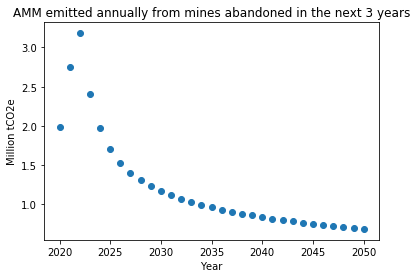

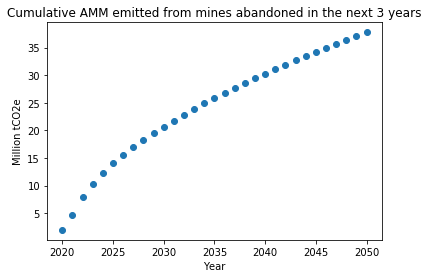

AMM emissions from mines abandoned in the next 3 years: 
    Year    mmcf/year  MtCO2e/year  MtCO2e (cumulative)
0   2020  4926.446583     1.992079             1.992079
1   2021  6808.173175     2.752981             4.745060
2   2022  7863.017871     3.179523             7.924583
3   2023  5960.716413     2.410300            10.334883
4   2024  4887.426567     1.976300            12.311183
5   2025  4225.241111     1.708536            14.019720
6   2026  3784.938198     1.530493            15.550213
7   2027  3471.608974     1.403794            16.954007
8   2028  3235.029016     1.308130            18.262137
9   2029  3047.489617     1.232296            19.494433
10  2030  2893.069605     1.169854            20.664287
11  2031  2762.216496     1.116941            21.781228
12  2032  2648.928294     1.071132            22.852360
13  2033  2549.250825     1.030826            23.883186
14  2034  2460.456265     0.994920            24.878106
15  2035  2380.581615     0.962622            2

In [12]:
## Import standard libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Some initial parameters.
years = [2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035, 2036, 
         2037, 2038, 2039, 2040, 2041, 2042, 2043, 2044, 2045, 2046, 2047, 2048, 2049, 2050]
eia_estimate = [442.861272, 428.98104, 435.525624, 415.021608, 411.54426, 394.532784, 409.4955, 408.471768,
            405.04014, 401.961816, 401.42394, 399.451068, 398.7099, 400.991436, 398.13984, 394.628148,
            392.405976, 391.904352, 388.400364, 386.64108, 385.63866, 384.313716, 384.122988,
            383.962608, 383.930532, 382.910616, 385.213068, 384.607296, 384.273828, 383.38416, 384.307416]
b = 2.017
Di_dry = 0.302
Di_flooded = 0.672
underground = 0.35

## Define inputs as functions.
def ask1():
    production_years = 0
    q1 = input("""I want to consider coal mine closures in the next __ years.
    (Input a number, or hit return for default.) """)
    if q1.isdigit():
        production_years = int(q1)
        return production_years
    elif q1.lower() == "":
        production_years = 3
        print("Default = 3 years.")
        return production_years
    else:
        print("Not a valid input.")
        return ask1()

def ask2():
    coal_production = []
    q2 = input("""Which coal production forecast?
    Input 'info' to see options, or hit return for default. """)
    if q2.lower() == "info":
        print("""'EIA': Energy Information Association's Annual Energy Outlook 2020 Coal Production Forecasts.""")
        return ask2()
    elif q2.lower() == "eia":
        coal_production = eia_estimate
        return coal_production
    elif q2 == "":
        coal_production = eia_estimate
        print("Default = EIA.")
        return coal_production
    else:
        print("Not a valid input.")
        return ask2()

def ask3():
    abandonment_rate = 0.0
    q3 = input("""What abandonment rate?
    (Input a percentage, or hit return for the default value of 5.) """)
    if q3 == "":
        abandonment_rate = .05
        print("Default = 5%.")
        return abandonment_rate
    else:
        try:
            if float(q3) >= 0 and float(q3) <= 100:
                    abandonment_rate = float(q3)/100
                    return abandonment_rate
            else:
                print("Not a valid input.")
                return ask3()
        except ValueError:
            print("Not a valid input.")
            return ask3()
    
def ask4():
    ef_leq200 = 0
    ef_200to400 = 0
    ef_geq400 = 0
    q4 = input("""Which set of emission factors?
    Input 'info' to see options, or hit return for default. """)
    if q4.lower() == "info":
        print("""
        'IPCC': IPCC's Tier 1 GHG inventory emission factors (2006).
        'M2CM': standard Languir isotherms, adjusted using a 1.7 emission factor coefficient
        (Kholod et al., 2020).
        'Manual': manually input emission factors for <200m, 200-400m, and >400m.""")
        return ask4()
    elif q4.lower() == "ipcc":
        ef_leq200 = 10
        ef_200to400 = 18
        ef_geq400 = 25
        return (ef_leq200, ef_200to400, ef_geq400)
    elif q4 == "":
        print("Default = IPCC.")
        ef_leq200 = 10
        ef_200to400 = 18
        ef_geq400 = 25
        return (ef_leq200, ef_200to400, ef_geq400)
    elif q4.lower() == "manual":
        try:
            ef_leq200 = float(input("<200m emission factor: "))
            ef_200to400 = float(input("200m to 400m emission factor: "))
            ef_geq400 = float(input(">400m emission factor: "))
            return (ef_leq200, ef_200to400, ef_geq400)
        except ValueError:
            print("Not a valid input.")
            return ask4()
    elif q4.lower() == "m2cm":
        ef_leq200 = 14.9
        ef_200to400 = 18.9
        ef_geq400 = 21.6
        return (ef_leq200, ef_200to400, ef_geq400)
    else:
        print("Not a valid input.")
        return ask4()
    
def ask5():
    flood_rate = 0.0
    q5 = input("""What abandoned mine flood rate would you like to use? 
    (Enter as a percentage, or hit return for the default value of 50.)""")
    if q5 == "":
        flood_rate = .5
        print("Default = 50%.")
        return flood_rate
    else:
        try:
            if float(q5) >= 0 and float(q5) <= 100:
                flood_rate = float(q5)/100
                return flood_rate
            else:
                print("Not a valid input.")
                return ask5()
        except ValueError:
            print("Not a valid input.")
            return ask5()
            
def cmm_to_amm():
    try:
        py = int(ask1())
        cp = ask2()[0:py]
        ar = float(ask3())
        efs = ask4()
        new_amm = [efs[1] * ar * x * 10 ** 6 for x in cp]
        fr = ask5()
        return (new_amm, py, fr)
    except TypeError:
        print("Whoops! Something went wrong. Let's start over.")
        return cmm_to_amm()
        
## Run calculator. Output is a MtCO2e vs year graph.

inputs = cmm_to_amm()
new_amm_cm = inputs[0]
closing_years = inputs[1]
fr = inputs[2]
i = 0
total_amm = []
while i < len(years):
    total_amm.append(0)
    i += 1
i = 0
while i < len(new_amm_cm):
    t = 0
    while t < len(years):
        if t < i:
            total_amm[t] += 0
        else:
            total_amm[t] += (1-fr) * underground * new_amm_cm[i]*((1+b*Di_dry*(t-i)) ** (-1/b))
            total_amm[t] += fr * underground * new_amm_cm[i]*np.exp(-t * Di_flooded)
        t+=1
    i+=1
total_amm_tco2e = [0.01428 * x for x in total_amm]
total_amm_Mtco2e = [x/(10**6) for x in total_amm_tco2e]

plt.scatter(x=years, y=total_amm_Mtco2e)
plt.xlabel("Year")
plt.ylabel("Million tCO2e")
if int(closing_years) == 1:
    plt.title("AMM emitted annually from mines abandoned in the next year")
elif int(closing_years) >= len(years):
    plt.title("AMM emitted annually from future mine closures, 2020-2050")
else:
    plt.title("AMM emitted annually from mines abandoned in the next %s years" % str(closing_years))
plt.show()

## Additional cumulative graph.

cumulative_amm_Mtco2e = []
i = 0
while i < len(total_amm_Mtco2e):
    cumulative_amm_Mtco2e.append(total_amm_Mtco2e[i])
    i+=1 
i = 0
while i < len(cumulative_amm_Mtco2e):
    t=0
    while t < i:
        cumulative_amm_Mtco2e[i]+=total_amm_Mtco2e[t]
        t+=1
    i+=1
    
plt.scatter(x=years, y=cumulative_amm_Mtco2e)
plt.xlabel("Year")
plt.ylabel("Million tCO2e")
if int(closing_years) == 1:
    plt.title("Cumulative AMM emitted from mines abandoned in the next year")
elif int(closing_years) >= len(years):
    plt.title("Cumulative AMM emitted from future mine closures, 2020-2050")
else:
    plt.title("Cumulative AMM emitted from mines abandoned in the next %s years" % str(closing_years))
plt.show()

total_amm_mmcf = [(x * 35.3147) / (10 ** 6) for x in total_amm]
total_amm_mmcf
df = pd.DataFrame()
df['Year']=pd.Series(years)
df['mmcf/year']=pd.Series(total_amm_mmcf)
df['MtCO2e/year']=pd.Series(total_amm_Mtco2e)
df['MtCO2e (cumulative)']=pd.Series(cumulative_amm_Mtco2e)
if int(closing_years) == 1:
    print("AMM emissions from mines abandoned in the next year: ")
elif int(closing_years) >= len(years):
    print("AMM emissions from future mine closures, 2020-2050: ")
else:
    print("AMM emissions from mines abandoned in the next %s years: " % str(closing_years))
print(df)